In [4]:
import os
os.environ["BRASA_DATA_PATH"] = "/mnt/d/brasa"

import sys
sys.path.append('..')

from datetime import datetime

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds
import pyarrow.compute as pc

import brasa

In [5]:
def calc_rsquared(symbols, year):
    s_market = brasa.get_returns("IBOV", start=datetime(year, 1, 1), end=datetime(year, 12, 31))
    s_assets = brasa.get_returns(symbols, start=datetime(year, 1, 1), end=datetime(year, 12, 31))
    model = sm.OLS(s_assets, sm.add_constant(s_market)).fit()
    params = model.params
    params.columns = s_assets.columns
    rsquared = ((params.iloc[1, :] ** 2) * s_market.var().item() / s_assets.var().values)
    df = pd.concat([rsquared, params.iloc[1, :], s_assets.sum()], axis=1)
    df.columns = ("rsquared", "beta", "returns")
    df["year"] = year
    return df

(87, 4)

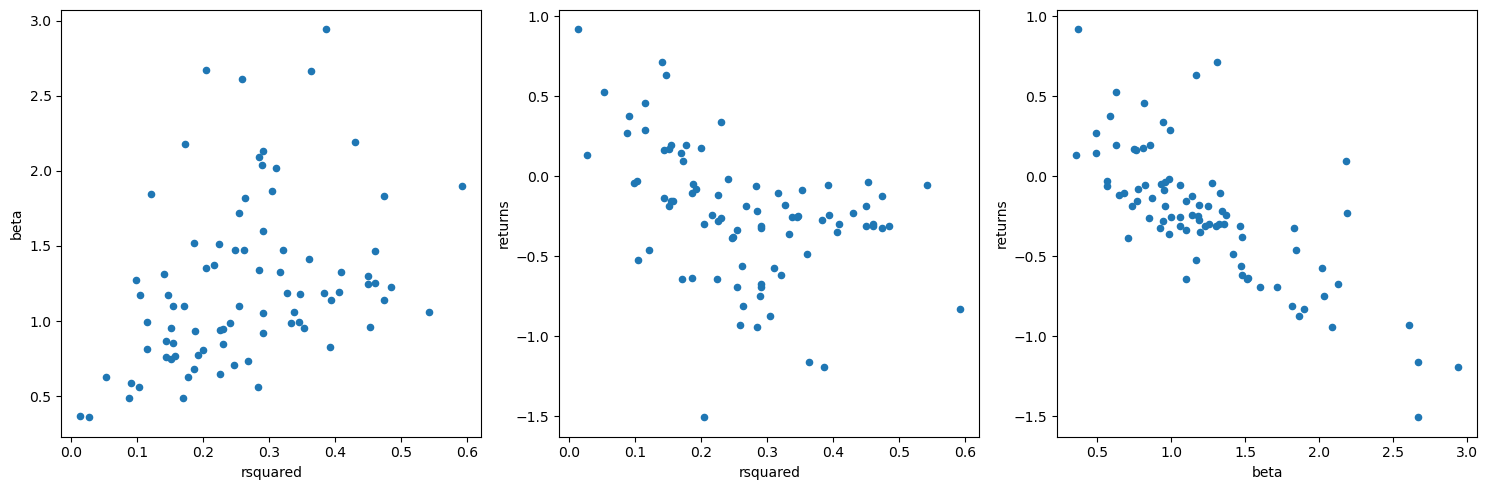

In [6]:
symbols = brasa.get_symbols("equity", index="IBOV")
rsquared = calc_rsquared(symbols, 2024)
display(rsquared.shape)
# bins = np.arange(0, 0.6, 0.1)
# bins = np.append(bins, 1)
# pd.cut(rsquared["rsquared"], bins).value_counts(normalize=True, sort=False).plot.bar(figsize=(24, 4))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

rsquared.plot.scatter(x="rsquared", y="beta", ax=axs[0])
rsquared.plot.scatter(x="rsquared", y="returns", ax=axs[1])
rsquared.plot.scatter(x="beta", y="returns", ax=axs[2])

fig.tight_layout()

plt.show()

In [11]:
years = [2021, 2022, 2023, 2024]
rsquared_x = [calc_rsquared(symbols, year).reset_index(inplace=False) for year in years]
rsquared = pd.concat(rsquared_x, axis=0)

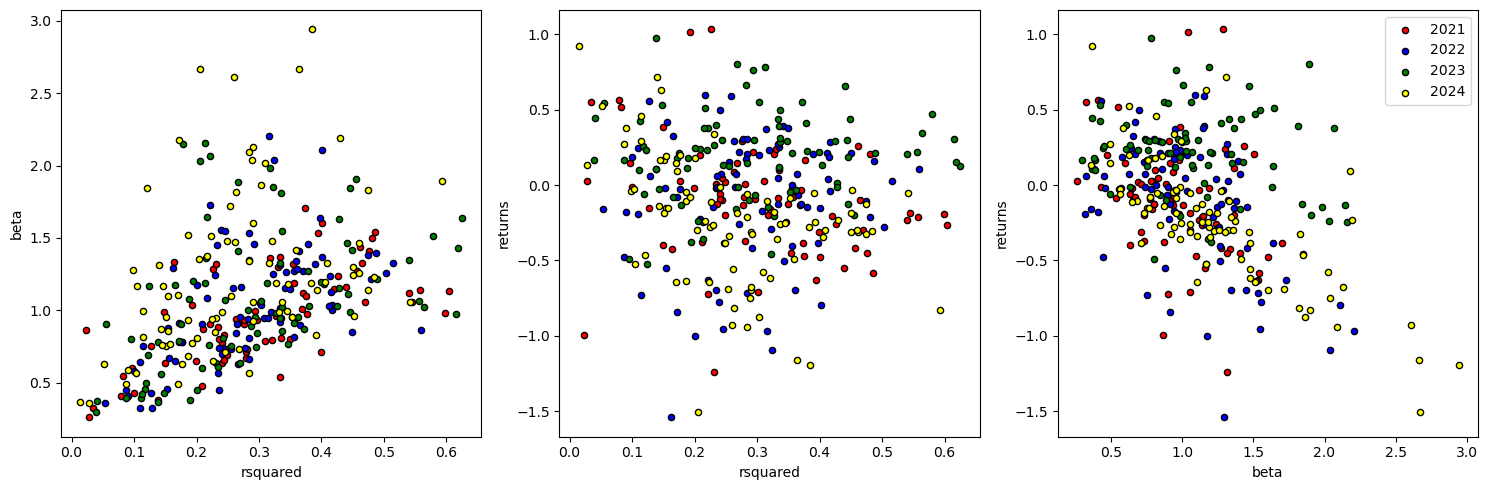

In [14]:
_colors = ["red", "blue", "green", "yellow", "magenta", "cyan", "black"]
colors = dict(zip(rsquared["year"].unique(), _colors))
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i,c in enumerate(rsquared["year"].unique()):
    ix = rsquared["year"] == c
    rsquared.loc[ix].plot.scatter(x="rsquared", y="beta", color=colors[c], edgecolors="black", ax=axs[0])
    rsquared.loc[ix].plot.scatter(x="rsquared", y="returns", color=colors[c], edgecolors="black", ax=axs[1])
    rsquared.loc[ix].plot.scatter(x="beta", y="returns", color=colors[c], ax=axs[2], label=c, edgecolors="black")
fig.tight_layout()
plt.show()